In [1]:
# Script to compare photo-z performance in redmapper clusters

import jplus
import numpy as np
from astropy.io import fits

xmatch_sdss = True



redmap_dir = '/home/CEFCA/aaorsi/work/redmapper/'
redmap_cat = '%sredmapper_dr8_public_v6.3_catalog.fits' % redmap_dir
redmap_mem = '%sredmapper_dr8_public_v6.3_members.fits' % redmap_dir

# loading J-PLUS catalogue
mag_type = 'gpsfMagsIso' 
gal_jplus0 = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='idr', allphotoz=True)

print 'J-PLUS catalogue loaded'
if xmatch_sdss:
    gal_sdss_coords  = jplus.datasets.fetch_custom_sdss(mag_type="none",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_r=False, get_i=False,
                                                    runname='coords', get_coords=True) 
    
    id_obj = np.argsort(gal_sdss_coords['object_id'])
    gal_sdss_coords['object_id'] = gal_sdss_coords['object_id'][id_obj]
    gal_sdss_coords['coords'] = gal_sdss_coords['coords'][id_obj,:]
    print 'SDSS coordinates loaded'
    
    gal_sdss_r_i  = jplus.datasets.fetch_custom_sdss(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 10, spectroscopic=False, 
                                                    casjobs=True, object_name="photgalaxies",get_r=True, get_i=True,
                                                    runname='r_i', get_coords=False)  
    
    id_obj = np.argsort(gal_sdss_r_i['object_id'])
    gal_sdss_r_i['object_id'] = gal_sdss_r_i['object_id'][id_obj]
    gal_sdss_r_i['rSDSS'] = gal_sdss_r_i['rSDSS'][id_obj,:]
    gal_sdss_r_i['iSDSS'] = gal_sdss_r_i['iSDSS'][id_obj,:]
    print 'SDSS ri loaded'
    print 'Cross-match of SDSS phot with J-PLUS ...'
    d,ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],gal_sdss_coords['coords'],max_distance=3e-4)
    m = ((d != np.inf))       
    jgal0 = jplus.tools.select_object(gal_jplus0, m)        
    jgal0['rSDSS'] = gal_sdss_r_i['rSDSS'][ind[m]]



    
mcat = jgal0 if xmatch_sdss else gal_jplus0



j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMagsIso_idr_dual_magmax24.0.h5
j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/coords_sdss_photgalaxies_none_magmax21.0.h5


J-PLUS catalogue loaded


j-plus [INFO]: Fetching SDSS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/r_i_sdss_photgalaxies_aperMags_magmax21.0.h5


SDSS coordinates loaded
SDSS ri loaded
Cross-match of SDSS phot with J-PLUS ...


In [2]:
# Load and prepare redmapper catalogue

fc = fits.open(redmap_cat)
rm_cat = fc[1].data

fm = fits.open(redmap_mem)
rm_mem = fm[1].data

print 'Redmapper data loaded'

mem_sel = rm_mem['p'] > 0.9 # Membership probability higher than 90%
nmem = len(np.where(mem_sel)[0])
print 'Number of RedMapper galaxies to cross-match with J-PLUS:%ld' %nmem

#rm_coords = [[rm_mem['RA'][mem_sel][i], rm_mem['DEC'][mem_sel][i]] for i in range(nmem)]
rm_ids = rm_mem['ID'][mem_sel]
rm_ra = rm_mem['RA'][mem_sel]
rm_dec = rm_mem['DEC'][mem_sel]


rm_zrm  = np.zeros(nmem)
rm_coords = np.zeros([nmem,2])
print 'Getting redshifts and coordinates from redmapper members'
for i in range(nmem):
    idz = np.where(rm_cat['ID'] == rm_ids[i])
    rm_zrm[i] = rm_cat['Z_LAMBDA'][idz] # The redshift of the cluster for each member
    rm_coords[i,:] = [rm_ra[i], rm_dec[i]]
    if i%10000 == 0:
        print i



Redmapper data loaded
Number of RedMapper galaxies to cross-match with J-PLUS:242814
Getting redshifts and coordinates from redmapper members
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


In [4]:
# Performing Cross-match

print 'Cross-match of Redmappper cluster members with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(mcat['coords'],rm_coords,max_distance=3e-4)
m = ((d != np.inf))
    
jrm = jplus.tools.select_object(mcat, m)
memj = ind[m]
jrm['z_redmapper'] = rm_zrm[ind[m]]
print jrm['z_redmapper']
print d, ind

print rm_coords


print 'done. %ld galaxies in J-PLUS and RedMapper'%len(jrm['tile_id'])

Cross-match of Redmappper cluster members with J-PLUS ...
[ 0.41008544  0.38599783  0.31855735 ...,  0.3404727   0.3404727   0.3404727 ]
[ inf  inf  inf ...,  inf  inf  inf] [242814 242814 242814 ..., 242814 242814 242814]
[[ 239.85233435   27.21684991]
 [ 239.81196798   27.17299655]
 [ 239.83922287   27.19653776]
 ..., 
 [ 153.81808387   43.62878777]
 [ 135.95009864   15.20462004]
 [ 135.96337099   15.20173173]]
done. 6329 galaxies in J-PLUS and RedMapper


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

def validate_photoz(samp, truez = 'zphoto', fig_name='photoz_val', 
                    xr = [0.01,0.99], yr = [0.01, 0.99],cmap=plt.cm.coolwarm,
                   ylabel='True redshifts', rlim = [21, 20, 19]):

    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure(fig_name)

    gs = gsc.GridSpec(len(rlim),3)
    gs.update(wspace=0.0, hspace=0.0)

   
    pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
    leg_list = ['LePhare', 'TPZ','BPZ']
    #rlim = [21, 20, 19]

    for j in range(len(rlim)):
        sel = samp['rJAVA'][:,0] < rlim[j]
        for i in range(3):
            ax = plt.subplot(gs[j,i])
            counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp[truez][sel], bins=40, 
                                                 range=[xr, yr],cmap=cmap, normed=LogNorm(), 
                                                 cmin=0.01, label=leg_list[i], alpha=0.9)
            ax.plot(xr,yr,'k--')
            ax.set_xlabel(leg_list[i],fontsize=20)

            if i == 0:
                ax.set_ylabel(ylabel,fontsize=20)
                ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
            else:
                ax.set_yticklabels([])

            if i == 2:
                ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(samp[truez][sel]), fontsize=15,transform=ax.transAxes)

    return fig




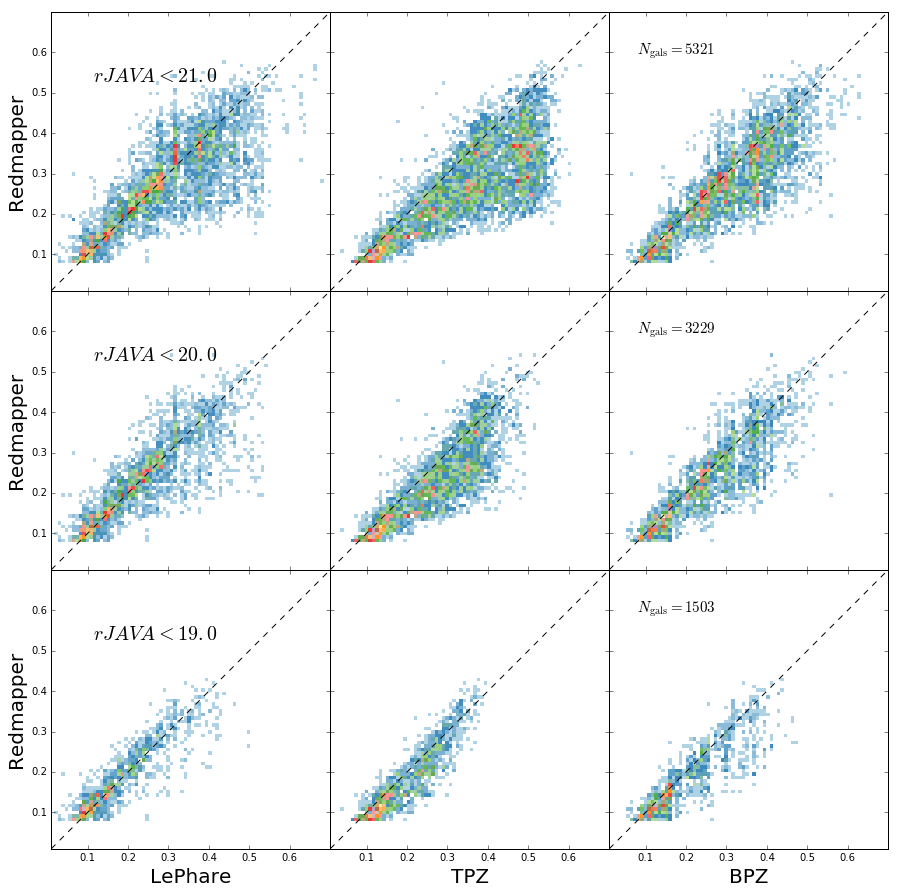

"\nplt.hist(gal_jplus0['photoz_leph'],bins=20,alpha=0.5,label='Lephare')\nplt.hist(gal_jplus0['photoz_bpz'],bins=20,alpha=0.5,label='BPZ')\nplt.hist(gal_jplus0['photoz_tpz'],bins=20,alpha=0.5,label='TPZ')\nplt.legend()\nplt.show()\n"

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

plt.rcParams['figure.figsize'] = 15, 15

plt.figure('Photoz_validation')
   
gs = gsc.GridSpec(3,3)
gs.update(wspace=0.0, hspace=0.0)

xr = [0.01,0.7]
yr = [0.01,0.7]

samp = jrm # change to jrm eventually

pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
leg_list = ['LePhare', 'TPZ','BPZ']
rlim = [21, 20, 19]

for j in range(3):
    sel = samp['rJAVA'][:,0] < rlim[j]
    for i in range(3):
        ax = plt.subplot(gs[j,i])
        counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp['z_redmapper'][sel], bins=80, 
                                             range=[xr, yr],cmap=plt.cm.Paired, normed=LogNorm(), 
                                             cmin=0.01, label=leg_list[i], alpha=0.9)
        ax.plot(xr,yr,'k--')
        ax.set_xlabel(leg_list[i],fontsize=20)
        
        if i == 0:
            ax.set_ylabel('Redmapper',fontsize=20)
            ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
       
        if i == 2:
            ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(samp['z_redmapper'][sel]), fontsize=15,transform=ax.transAxes)

plt.show()







"""
plt.hist(gal_jplus0['photoz_leph'],bins=20,alpha=0.5,label='Lephare')
plt.hist(gal_jplus0['photoz_bpz'],bins=20,alpha=0.5,label='BPZ')
plt.hist(gal_jplus0['photoz_tpz'],bins=20,alpha=0.5,label='TPZ')
plt.legend()
plt.show()
"""

In [6]:

%debug


ERROR:root:No traceback has been produced, nothing to debug.


In [11]:
# Cross-match with ALHAMBRA catalogue

print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(mcat['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))
jp_alh = jplus.tools.select_object(mcat, alh_m)


# Cross match with ELG selection.... 
alha_xjp = jplus.tools.select_object(alh, alh_ind[alh_m])
jp_alh['zphoto'] = alha_xjp['zphoto']

print len(jp_alh['zphoto'])


Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
1555


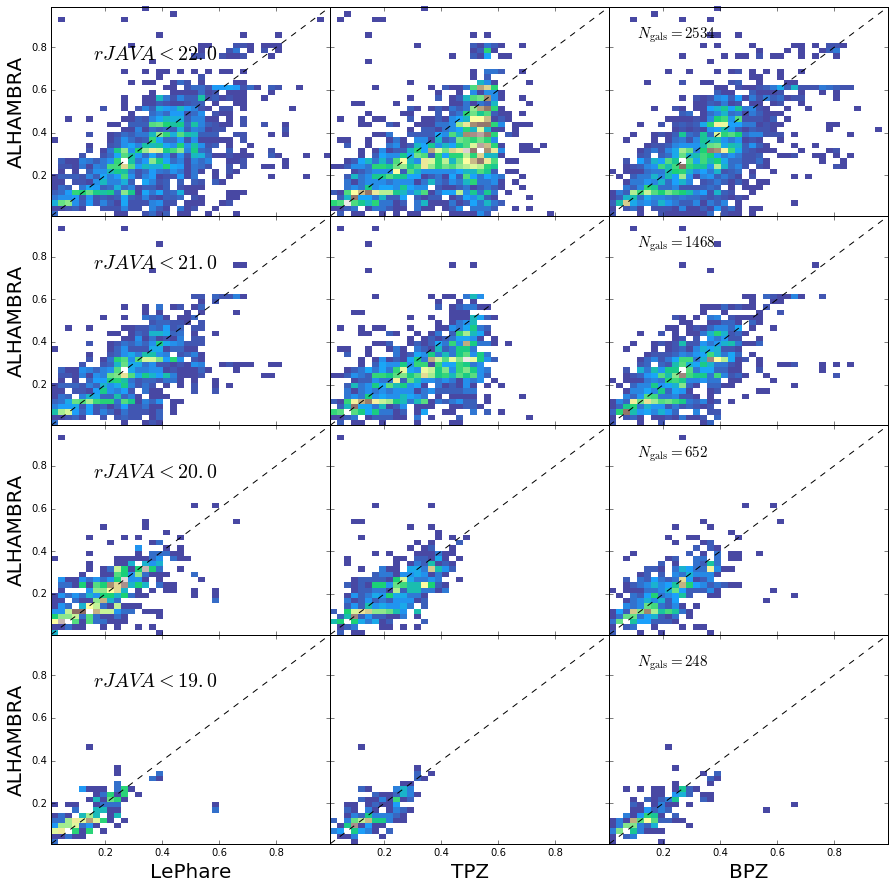

In [8]:
# And plots

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

aff = validate_photoz(jp_alh, rlim=[22,21,20,19], ylabel='ALHAMBRA', cmap=plt.cm.terrain)






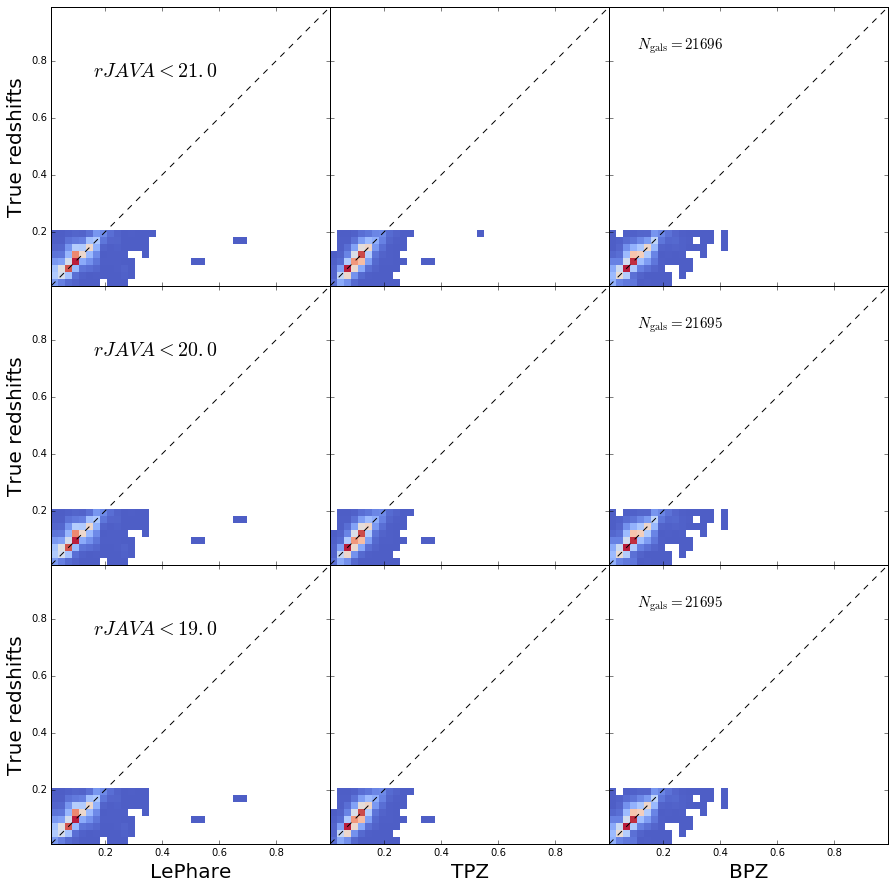

In [9]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

# Load Yang's catalogue
import numpy as np

yang_cat = '/home/CEFCA/aaorsi/work/yang/petroA_group'
ra_y, dec_y, z_y = np.loadtxt(yang_cat,usecols=(1,2,3), unpack=True)
ny = len(z_y)

coords_y = np.asarray([[ra_y[i], dec_y[i]] for i in range(ny)])

d,ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],coords_y,max_distance=3e-4)
mask = ((d != np.inf))
jp_yang = jplus.tools.select_object(gal_jplus0, mask)

# Cross match with ELG selection.... 
jp_yang['zphoto'] = z_y[ind[mask]]

fig = validate_photoz(jp_yang)






In [14]:
Compare_JPLUSES = True
if Compare_JPLUSES:
    
    mag_type = 'gpsfMags' 
    gal_jplus_old = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='dr1', allphotoz=True)
    
    if xmatch_sdss:
        print 'Cross-match of SDSS phot with J-PLUS ...'
        d,ind = jplus.tools.crossmatch_angular(gal_jplus_old['coords'],gal_sdss_coords['coords'],max_distance=3e-4)
        m = ((d != np.inf))       
        jgal1 = jplus.tools.select_object(gal_jplus_old, m)        
        jgal1['rSDSS'] = gal_sdss_r_i['rSDSS'][ind[m]]
        
    scat = jgal1 if xmatch_sdss else gal_jplus_old

    J1 = 'DR1-cand.'
    
    print 'Cross-matching catalogues ...'
    # Cross-match with ALHAMBRA
    alh_d,alh_ind = jplus.tools.crossmatch_angular(scat['coords'],alh['coords'],max_distance=3e-4)
    alh_m = ((alh_d != np.inf))
    jp_old_alh = jplus.tools.select_object(scat, alh_m)
    alha_xjp = jplus.tools.select_object(alh, alh_ind[alh_m])
    jp_old_alh['zphoto'] = alha_xjp['zphoto']

    # Cross-match with RedMapper
    d,ind = jplus.tools.crossmatch_angular(scat['coords'],rm_coords,max_distance=3e-4)
    m = ((d != np.inf))
    
    j_oldrm = jplus.tools.select_object(scat, m)
    memj = ind[m]
    j_oldrm['z_redmapper'] = rm_zrm[ind[m]]
    print 'Done...'


j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax24.0.h5


Cross-match of SDSS phot with J-PLUS ...
Cross-matching catalogues ...
Done...


2
bin: 2
7
bin: 7
12
bin: 12
16
bin: 16
21
bin: 21
32
bin: 32
35
bin: 35
3
bin: 3
6
bin: 6
9
bin: 9
16
bin: 16
22
bin: 22
30
bin: 30
31
bin: 31
0
bin: 0
2
bin: 2
6
bin: 6
11
bin: 11
22
bin: 22
32
bin: 32
38
bin: 38
0
bin: 0
4
bin: 4
9
bin: 9
11
bin: 11
24
bin: 24
31
bin: 31
34
bin: 34
2
bin: 2
4
bin: 4
8
bin: 8
16
bin: 16
19
bin: 19
28
bin: 28
37
bin: 37
2
bin: 2
5
bin: 5
8
bin: 8
12
bin: 12
16
bin: 16
28
bin: 28
30
bin: 30
0
bin: 0
3
bin: 3
5
bin: 5
11
bin: 11
19
bin: 19
28
bin: 28
37
bin: 37
0
bin: 0
2
bin: 2
7
bin: 7
10
bin: 10
16
bin: 16
27
bin: 27
30
bin: 30
2
bin: 2
5
bin: 5


TypeError: Improper input: N=3 must not exceed M=0

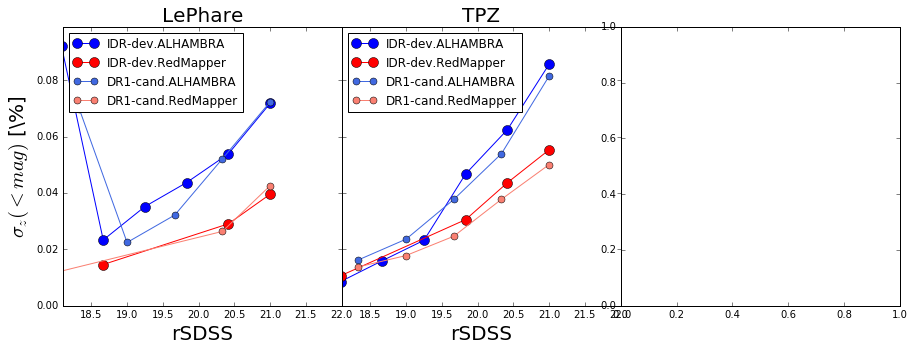

In [53]:
def mag_sigma(gal, photoz, label=None, zspeckey='zphoto', color='red', magx = 'rJAVA',fontsize=15,mlim=[18,21],markersize=10):
    mag_limit = np.linspace(mlim[0],mlim[1],7)
    sigma = []
    delta_z  = (gal[zspeckey] - photoz)/(1 + gal[zspeckey])
    for mlim in mag_limit:
        
        hist, bins = np.histogram(delta_z[gal[magx][:,0] < mlim], bins=np.linspace(-0.3, 0.3, 40))
        bin_centres = (bins[:-1] + bins[1:])/2
        nzero = hist > 0
        nh = len(delta_z[gal[magx][:,0] < mlim])
        print len(hist[nzero])
        print 'bin:',len(bin_centres[nzero])
        if (len(hist[nzero]) < 4) | (nh < 4):
            sigma.append(np.nan)
        else:
            #print 'hist:',hist
            #print 'delta_z:', delta_z[gal[magx][:,0] < mlim]

            xx_fit, yy_fit, coeff, outl_frac = jplus.plotting.compute_sigma(bin_centres, hist, delta_z[gal[magx][:,0] < mlim])
            sigma.append(coeff[2])
    
    gs = np.asarray(sigma) < 0.1
    plt.plot(mag_limit[gs], np.asarray(sigma)[gs], '-o', label=label, color=color,markersize=markersize)
    plt.xlim([16.5, 22])
    plt.ylim([0.0, 0.07])
    plt.ylabel("$\sigma_z( < mag)$ [\%]",fontsize=fontsize)
    plt.xlabel("%s [mag]" % magx)
    #print np.asarray(sigma)[gs]
    plt.legend(loc='upper left')
    

xr = [18.1,22]
yr = [0.,0.099]

pz_list = ['photoz_leph', 'photoz_tpz', 'photoz_bpz']
leg_list = ['LePhare', 'TPZ','BPZ']
rlim = [21]

J0    = 'IDR-dev.' if Compare_JPLUSES else ''


for j in range(1):
    sel_alh = jp_alh['rSDSS'][:,0] < rlim[j]
    sel_rm = jrm['rSDSS'][:,0] < rlim[j]
    if Compare_JPLUSES:
        sel2_alh = jp_old_alh['rSDSS'][:,0] < rlim[j]
        sel2_rm = j_oldrm['rSDSS'][:,0] < rlim[j]
  

    for i in range(3):
        ax = plt.subplot(gs[j,i])
        jp_sel = jplus.tools.select_object(jp_alh, sel_alh)
        jp_rm  = jplus.tools.select_object(jrm, sel_rm)
        
        if Compare_JPLUSES:
            jp2_sel = jplus.tools.select_object(jp_old_alh, sel2_alh)
            jp2_rm  = jplus.tools.select_object(j_oldrm, sel2_rm)
            
        
        mag_sigma(jp_sel, jp_sel[pz_list[i]], zspeckey='zphoto',label=J0+'ALHAMBRA', color='blue',
                  mlim=[17.5,rlim[j]],fontsize=20, magx='rSDSS')
        mag_sigma(jp_rm, jp_rm[pz_list[i]], zspeckey='z_redmapper',label=J0+'RedMapper', color='red',
                  mlim=[17.5,rlim[j]],fontsize=20, magx='rSDSS')
        
        if Compare_JPLUSES:
            mag_sigma(jp2_sel, jp2_sel[pz_list[i]], zspeckey='zphoto',label=J1+'ALHAMBRA', 
                      color='royalblue',mlim=[17.,rlim[j]],fontsize=20,markersize=7, magx='rSDSS')
            mag_sigma(jp2_rm, jp2_rm[pz_list[i]], zspeckey='z_redmapper',label=J1+'RedMapper', 
                      color='salmon',mlim=[17.,rlim[j]],fontsize=20, markersize=7, magx='rSDSS')
        
        #mag_sigma(jp_y, jp_y[pz_list[i]], zspeckey='zphoto',label='Yang groups', color='green',mlim=[15.,rlim[j]],fontsize=20)
        
        ax.set_xlim(xr)
        ax.set_ylim(yr)
        ax.set_xlabel('rSDSS',fontsize=20)
        
        if j == 0:
            ax.set_title(leg_list[i],fontsize=20)
        if i > 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
       
        if i == 2:
            ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(jp_sel['zphoto']), fontsize=15,transform=ax.transAxes,color='blue')
            ax.text(0.1,0.75,r'$N_{\rm gals}=%ld$'% len(jp_rm['z_redmapper']), fontsize=15,transform=ax.transAxes,color='red')
            #ax.text(0.1,0.65,r'$N_{\rm gals}=%ld$'% len(jp_yang['zphoto']), fontsize=15,transform=ax.transAxes,color='green')

plt.show()
    


145650
145650
[[ 2.66145258 -0.05115754]
 [ 2.66160747 -0.06293948]
 [ 2.66141912 -0.05573854]
 ..., 
 [ 3.80684744 -0.03607256]
 [ 3.80694343 -0.03616031]
 [ 3.80680963 -0.03996465]]
number of objects in xmatch: 0


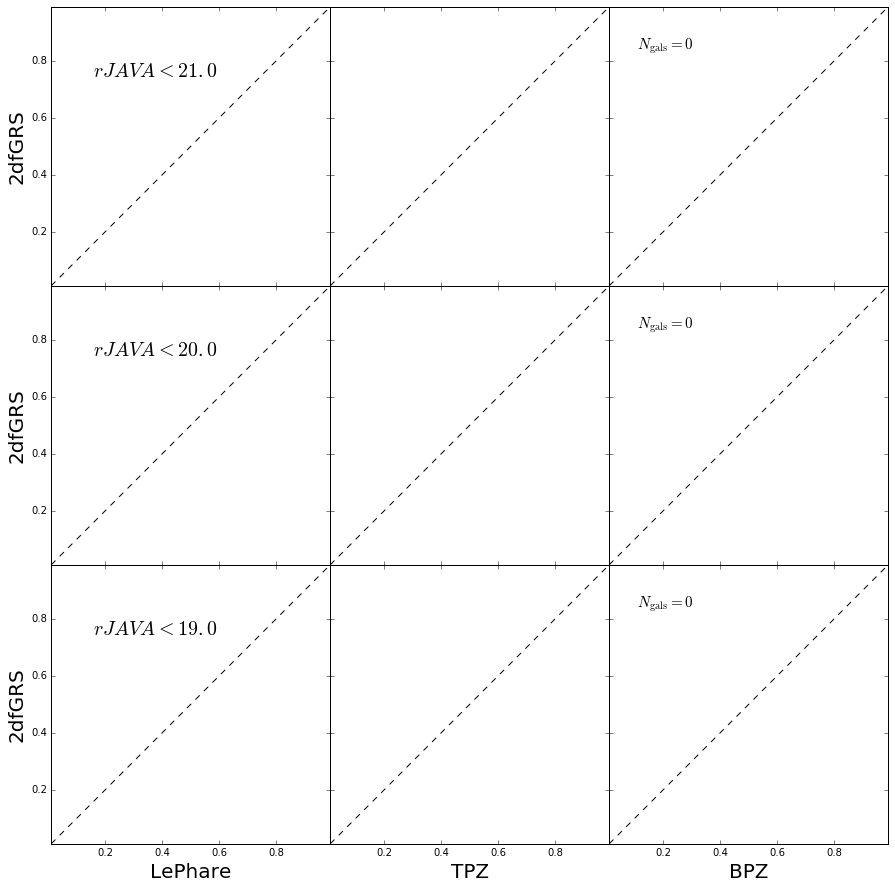

In [11]:
# 2DFGRS catalogue
import numpy as np
two2dfcat = '/home/CEFCA/aaorsi/work/2dfgrs/parent.ngp.txt'

ra_2df, dec_2df, z_2df = np.loadtxt(two2dfcat, usecols=(1,2,4), unpack=True)
ng = len(z_2df)
print ng

coords_2df = np.asarray([[ra_2df[i], dec_2df[i]] for i in range(ng)])
print len(coords_2df)
print coords_2df[0:-100]
d,ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],coords_2df,max_distance=3e-1)
mask = ((d != np.inf))
jp_2df = jplus.tools.select_object(gal_jplus0, mask)

# Cross match with ELG selection.... 
jp_2df['zphoto'] = z_2df[ind[mask]]

print 'number of objects in xmatch: %ld' % len(ind[mask])

fig = validate_photoz(jp_2df, ylabel='2dfGRS')

# 0 galaxies to compare with :(




number of objects in xmatch: 0


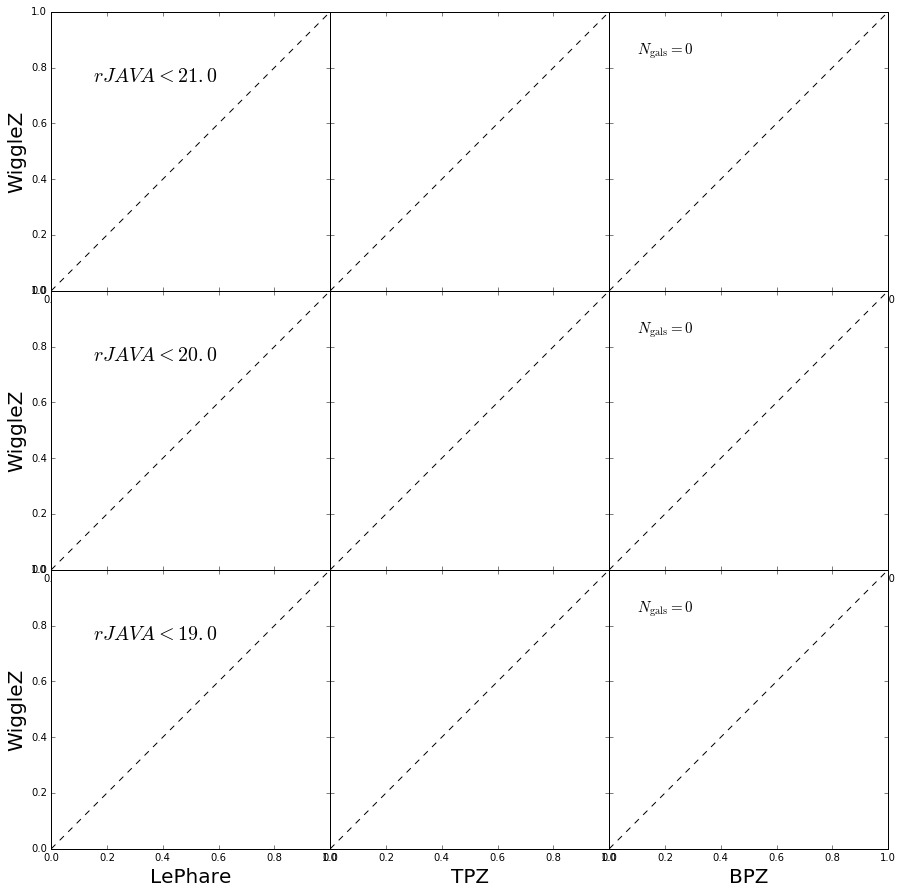

Type:        module
String form: <module 'jplus.healpix.healpix_maps' from '/home/CEFCA/aaorsi/anaconda2/envs/photozenv/lib/python2.7/site-packages/jplus-0.1-py2.7.egg/jplus/healpix/healpix_maps.pyc'>
File:        ~/anaconda2/envs/photozenv/lib/python2.7/site-packages/jplus-0.1-py2.7.egg/jplus/healpix/healpix_maps.py
Docstring:   <no docstring>


In [12]:
# Wigglez catalogue... i'm using the same variable names as for 2dfgrs
import numpy as np
from astropy.io import fits

two2dfcat = '/home/CEFCA/aaorsi/work/wigglez/wigglez_dr1.fits'

ff = fits.open(two2dfcat)
wigglez= ff[1].data

ra_2df  = wigglez['RA']
dec_2df = wigglez['DEC']
z_2df   = wigglez['Redshift']

#ra_2df, dec_2df, z_2df = np.loadtxt(two2dfcat, usecols=(1,2,3), unpack=True)






ng = len(z_2df)

coords_g = np.asarray([[ra_2df[i], dec_2df[i]] for i in range(ng)])

d,ind = jplus.tools.crossmatch_angular(gal_jplus0['coords'],coords_g,max_distance=3e-4)
mask = ((d != np.inf))
jp_2df = jplus.tools.select_object(gal_jplus0, mask)

# Cross match with ELG selection.... 
jp_2df['zphoto'] = z_2df[ind[mask]]

print 'number of objects in xmatch: %ld' % len(ind[mask])

fig = validate_photoz(jp_2df, ylabel='WiggleZ', xr=[0,1], yr=[0,1])

jplus.healpix.healpix_maps?


# 0 galaxies to compare with :(


TypeError: It is not possible to change axes limits for geographic projections. Please consider using Basemap or Cartopy.

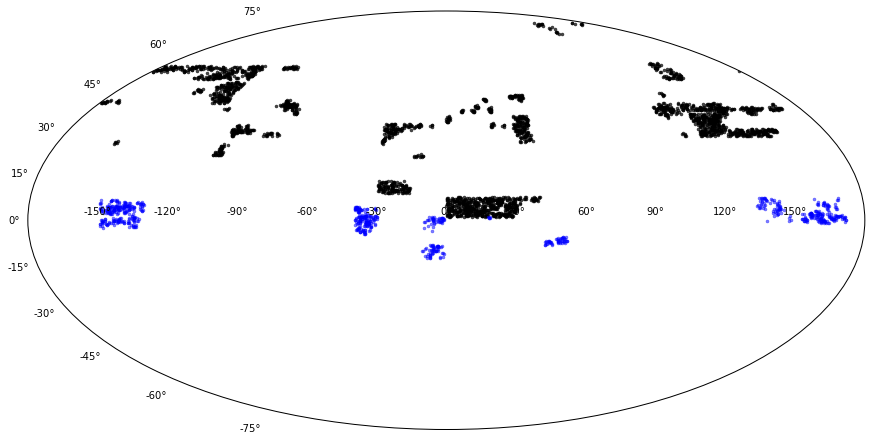

In [13]:
import astropy.coordinates as coord
import astropy.units as u

ljp = len(gal_jplus0['coords'])
jpid = np.random.random_integers(0,ljp,int(ljp/1000))

ra = coord.Angle(gal_jplus0['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(gal_jplus0['coords'][jpid,1]*u.degree)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.plot(ra.radian, dec.radian,'k.', label='J-PLUS', alpha=0.7)

#counts, ybins, xbins, image = plt.hist2d(ra.radian, dec.radian, bins=250, 
#                                         cmap=plt.cm.Greys, normed=LogNorm(), 
#                                         cmin=0.01, label='J-PLUS', alpha=0.8)

lw = len(ra_2df)
wid = np.random.random_integers(0,lw,int(lw/100))
ra_2 = coord.Angle(ra_2df[wid]*u.degree)
ra_2 = ra_2.wrap_at(180*u.degree)
dec_2 = coord.Angle(dec_2df[wid]*u.degree)

#counts, ybins, xbins, image = plt.hist2d(ra_2.radian, dec_2.radian, bins=250, 
#                                         cmap=plt.cm.Blues, normed=LogNorm(), 
#                                         cmin=0.01, label='WiggleZ', alpha=0.8)

ax.plot(ra_2.radian, dec_2.radian,'.',alpha=0.5,color='blue', label='WiggleZ')

ax.set_xlim([0,50])
ax.set_ylim([-10,20])

ax.legend()



In [ ]:
from mpl_toolkits.basemap import Basemap, cm



